<a href="https://colab.research.google.com/github/AGLendon/MusicEngineeringProject/blob/main/ME_RNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install pyyaml h5py 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!pip install fluidsynth

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!pip install pretty_midi

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import collections
import datetime
import fluidsynth
import glob
import numpy as np
import pathlib
import pandas as pd
import pretty_midi
import seaborn as sns
import tensorflow as tf

from IPython import display
from matplotlib import pyplot as plt
from typing import Dict, List, Optional, Sequence, Tuple

In [ ]:
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)

# Sampling rate for audio playback
_SAMPLING_RATE = 16000

In [ ]:
data_dir = pathlib.Path('data/maestro-v2.0.0')
if not data_dir.exists():
  tf.keras.utils.get_file(
      'maestro-v2.0.0-midi.zip',
      origin='https://storage.googleapis.com/magentadata/datasets/maestro/v2.0.0/maestro-v2.0.0-midi.zip',
      extract=True,
      cache_dir='.', cache_subdir='data',
  )

#data_dir = pathlib.Path('/content/En_A')

In [ ]:

filenames = glob.glob(str(data_dir/'**/*.mid*'))
#filenames = glob.glob(str(data_dir/'*.mid'))
print(filenames)
print('Number of files:', len(filenames))
#pm = pretty_midi.PrettyMIDI(sample_file)

['data/maestro-v2.0.0/2009/MIDI-Unprocessed_08_R2_2009_01_ORIG_MID--AUDIO_08_R2_2009_08_R2_2009_02_WAV.midi', 'data/maestro-v2.0.0/2009/MIDI-Unprocessed_09_R2_2009_01_ORIG_MID--AUDIO_09_R2_2009_09_R2_2009_02_WAV.midi', 'data/maestro-v2.0.0/2009/MIDI-Unprocessed_16_R2_2009_01_ORIG_MID--AUDIO_16_R2_2009_16_R2_2009_01_WAV.midi', 'data/maestro-v2.0.0/2009/MIDI-Unprocessed_08_R1_2009_01-04_ORIG_MID--AUDIO_08_R1_2009_08_R1_2009_04_WAV.midi', 'data/maestro-v2.0.0/2009/MIDI-Unprocessed_11_R1_2009_01-05_ORIG_MID--AUDIO_11_R1_2009_11_R1_2009_04_WAV.midi', 'data/maestro-v2.0.0/2009/MIDI-Unprocessed_17_R2_2009_01_ORIG_MID--AUDIO_17_R2_2009_17_R2_2009_03_WAV.midi', 'data/maestro-v2.0.0/2009/MIDI-Unprocessed_02_R1_2009_01-02_ORIG_MID--AUDIO_02_R1_2009_02_R1_2009_01_WAV.midi', 'data/maestro-v2.0.0/2009/MIDI-Unprocessed_07_R1_2009_01-03_ORIG_MID--AUDIO_07_R1_2009_07_R1_2009_02_WAV.midi', 'data/maestro-v2.0.0/2009/MIDI-Unprocessed_17_R1_2009_01-03_ORIG_MID--AUDIO_17_R1_2009_17_R1_2009_02_WAV.midi', 'da

In [ ]:
def display_audio(pm: pretty_midi.PrettyMIDI, seconds=30):
  waveform = pm.fluidsynth(fs=_SAMPLING_RATE)
  # Take a sample of the generated waveform to mitigate kernel resets
  waveform_short = waveform[:seconds*_SAMPLING_RATE]
  return display.Audio(waveform_short, rate=_SAMPLING_RATE)

In [ ]:
def midi_to_notes(midi_file: str) -> pd.DataFrame:
  pm = pretty_midi.PrettyMIDI(midi_file)
  instrument = pm.instruments[0]
  notes = collections.defaultdict(list)

  # Sort the notes by start time
  sorted_notes = sorted(instrument.notes, key=lambda note: note.start)
  prev_start = sorted_notes[0].start

  for note in sorted_notes:
    start = note.start
    end = note.end
    notes['pitch'].append(note.pitch)
    notes['start'].append(start)
    notes['end'].append(end)
    notes['step'].append(start - prev_start)
    notes['duration'].append(end - start)
    prev_start = start

  return pd.DataFrame({name: np.array(value) for name, value in notes.items()})

In [ ]:
def plot_piano_roll(notes: pd.DataFrame, count: Optional[int] = None):
  if count:
    title = f'First {count} notes'
  else:
    title = f'Whole track'
    count = len(notes['pitch'])
  plt.figure(figsize=(20, 4))
  plot_pitch = np.stack([notes['pitch'], notes['pitch']], axis=0)
  plot_start_stop = np.stack([notes['start'], notes['end']], axis=0)
  plt.plot(
      plot_start_stop[:, :count], plot_pitch[:, :count], color="b", marker=".")
  plt.xlabel('Time [s]')
  plt.ylabel('Pitch')
  _ = plt.title(title)

In [ ]:
def plot_distributions(notes: pd.DataFrame, drop_percentile=2.5):
  plt.figure(figsize=[15, 5])
  plt.subplot(1, 3, 1)
  sns.histplot(notes, x="pitch", bins=20)

  plt.subplot(1, 3, 2)
  max_step = np.percentile(notes['step'], 100 - drop_percentile)
  sns.histplot(notes, x="step", bins=np.linspace(0, max_step, 21))

  plt.subplot(1, 3, 3)
  max_duration = np.percentile(notes['duration'], 100 - drop_percentile)
  sns.histplot(notes, x="duration", bins=np.linspace(0, max_duration, 21))

In [ ]:
sample_file = filenames[87]
print(sample_file)
raw_notes = midi_to_notes(sample_file)
raw_notes.head()



data/maestro-v2.0.0/2009/MIDI-Unprocessed_06_R1_2009_03-07_ORIG_MID--AUDIO_06_R1_2009_06_R1_2009_05_WAV.midi


,pitch,start,end,step,duration
0,59,0.988281,2.118490,0.000000,1.130208
1,68,2.029948,3.680990,1.041667,1.651042
2,40,2.108073,2.433594,0.078125,0.325521
3,61,3.173177,3.602865,1.065104,0.429688
4,52,3.180990,3.532552,0.007812,0.351562


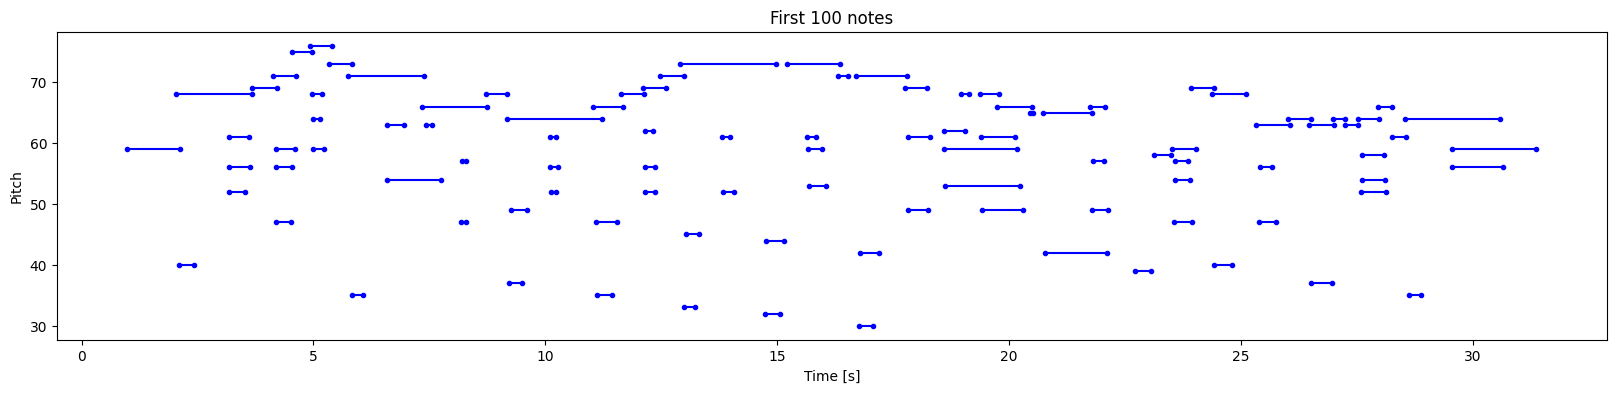

In [ ]:
plot_piano_roll(raw_notes, count=100)

In [ ]:
#num_files = 100
#all_notes = []
#for f in filenames[:num_files]:
#  notes = midi_to_notes(f)
#  all_notes.append(notes)

#all_notes = pd.concat(all_notes)

num_files = 5
all_notes = []
for f in filenames[:num_files]:
  notes = midi_to_notes(f)
  all_notes.append(notes)

all_notes = pd.concat(all_notes)

In [ ]:
n_notes = len(all_notes)
print('Number of notes parsed:', n_notes)

Number of notes parsed: 20402


In [ ]:
key_order = ['pitch', 'step', 'duration']
train_notes = np.stack([all_notes[key] for key in key_order], axis=1)
notes_ds = tf.data.Dataset.from_tensor_slices(train_notes)
notes_ds.element_spec

TensorSpec(shape=(3,), dtype=tf.float64, name=None)

In [ ]:
def create_sequences(
    dataset: tf.data.Dataset, 
    seq_length: int,
    vocab_size = 128,#,
) -> tf.data.Dataset:
  """Returns TF Dataset of sequence and label examples."""
  seq_length = seq_length+1

  # Take 1 extra for the labels
  windows = dataset.window(seq_length, shift=1, stride=1,
                              drop_remainder=True)

  # `flat_map` flattens the" dataset of datasets" into a dataset of tensors
  flatten = lambda x: x.batch(seq_length, drop_remainder=True)
  sequences = windows.flat_map(flatten)

  # Normalize note pitch
  def scale_pitch(x):
    x = x/[vocab_size,1.0,1.0]
    return x

  # Split the labels
  def split_labels(sequences):
    inputs = sequences[:-1]
    labels_dense = sequences[-1]
    labels = {key:labels_dense[i] for i,key in enumerate(key_order)}

    return scale_pitch(inputs), labels

  return sequences.map(split_labels, num_parallel_calls=tf.data.AUTOTUNE)

In [ ]:
seq_length = 25 #10 PC #TODO! Make variable!
vocab_size = 128 #PC
seq_ds = create_sequences(notes_ds, seq_length, vocab_size)
seq_ds.element_spec

(TensorSpec(shape=(25, 3), dtype=tf.float64, name=None),
 {'pitch': TensorSpec(shape=(), dtype=tf.float64, name=None),
  'step': TensorSpec(shape=(), dtype=tf.float64, name=None),
  'duration': TensorSpec(shape=(), dtype=tf.float64, name=None)})

In [ ]:
for seq, target in seq_ds.take(1):
  print('sequence shape:', seq.shape)
  print('sequence elements (first 10):', seq[0: 10])
  print()
  print('target:', target)

sequence shape: (25, 3)
sequence elements (first 10): tf.Tensor(
[[0.4453125  0.         0.74088542]
 [0.5390625  0.01041667 0.77734375]
 [0.5546875  0.35416667 0.53645833]
 [0.4609375  0.02604167 0.33854167]
 [0.5703125  0.3046875  0.7421875 ]
 [0.4765625  0.03776042 0.15885417]
 [0.578125   0.42578125 2.07421875]
 [0.484375   0.00520833 1.74609375]
 [0.390625   0.01302083 2.04296875]
 [0.421875   0.015625   2.21354167]], shape=(10, 3), dtype=float64)

target: {'pitch': <tf.Tensor: shape=(), dtype=float64, numpy=66.0>, 'step': <tf.Tensor: shape=(), dtype=float64, numpy=0.06640625>, 'duration': <tf.Tensor: shape=(), dtype=float64, numpy=0.140625>}


In [ ]:
batch_size = 64 
buffer_size = n_notes - seq_length  # the number of items in the dataset
train_ds = (seq_ds
            .shuffle(buffer_size)
            .batch(batch_size, drop_remainder=True)
            .cache()
            .prefetch(tf.data.experimental.AUTOTUNE))

In [ ]:
train_ds.element_spec

(TensorSpec(shape=(64, 25, 3), dtype=tf.float64, name=None),
 {'pitch': TensorSpec(shape=(64,), dtype=tf.float64, name=None),
  'step': TensorSpec(shape=(64,), dtype=tf.float64, name=None),
  'duration': TensorSpec(shape=(64,), dtype=tf.float64, name=None)})

In [ ]:
def mse_with_positive_pressure(y_true: tf.Tensor, y_pred: tf.Tensor):
  mse = (y_true - y_pred) ** 2
  positive_pressure = 10 * tf.maximum(-y_pred, 0.0)
  return tf.reduce_mean(mse + positive_pressure)

In [ ]:
input_shape = (seq_length, 3)
learning_rate = 0.005 #0.005 PC

inputs = tf.keras.Input(input_shape)
x = tf.keras.layers.LSTM(128)(inputs)

outputs = {
  'pitch': tf.keras.layers.Dense(128, name='pitch')(x),   #128, name='pitch')(x),  PC
  'step': tf.keras.layers.Dense(1, name='step')(x),
  'duration': tf.keras.layers.Dense(1, name='duration')(x),
}

model = tf.keras.Model(inputs, outputs)

loss = {
      'pitch': tf.keras.losses.SparseCategoricalCrossentropy(
          from_logits=True),
      'step': mse_with_positive_pressure,
      'duration': mse_with_positive_pressure,
}

optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

model.compile(loss=loss, optimizer=optimizer)

model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 25, 3)]      0           []                               
                                                                                                  
 lstm_2 (LSTM)                  (None, 128)          67584       ['input_3[0][0]']                
                                                                                                  
 duration (Dense)               (None, 1)            129         ['lstm_2[0][0]']                 
                                                                                                  
 pitch (Dense)                  (None, 128)          16512       ['lstm_2[0][0]']                 
                                                                                            

In [ ]:
losses = model.evaluate(train_ds, return_dict=True)
losses

318/318 [==============================] - 21s 40ms/step - loss: 5.0263 - duration_loss: 0.1180 - pitch_loss: 4.8516 - step_loss: 0.0567


{'loss': 5.026315212249756,
 'duration_loss': 0.11799263954162598,
 'pitch_loss': 4.851602554321289,
 'step_loss': 0.056720126420259476}

In [ ]:
model.compile(
    loss=loss,
    loss_weights={
        'pitch': 0.05,
        'step': 1.0,
        'duration':1.0,
    },
    optimizer=optimizer,
    metrics = ["accuracy"]
)

In [ ]:
model.evaluate(train_ds, return_dict=True)

318/318 [==============================] - 18s 41ms/step - loss: 0.4173 - duration_loss: 0.1180 - pitch_loss: 4.8516 - step_loss: 0.0567 - duration_accuracy: 0.0000e+00 - pitch_accuracy: 4.9135e-05 - step_accuracy: 0.0430


{'loss': 0.41729286313056946,
 'duration_loss': 0.11799263954162598,
 'pitch_loss': 4.851602554321289,
 'step_loss': 0.056720126420259476,
 'duration_accuracy': 0.0,
 'pitch_accuracy': 4.9135218432638794e-05,
 'step_accuracy': 0.04304245114326477}

In [ ]:
callbacks = [
    tf.keras.callbacks.ModelCheckpoint(
        filepath='./training_checkpoints/ckpt_{epoch}',
        save_weights_only=True),
    tf.keras.callbacks.EarlyStopping(
        monitor='loss',
        patience=3,
        verbose=1,
        restore_best_weights=True),
]

In [ ]:
%%time
epochs = 150

history = model.fit(
    train_ds,
    epochs=epochs,
    callbacks=callbacks,
)

Epoch 1/150
318/318 [==============================] - 19s 50ms/step - loss: 0.3165 - duration_loss: 0.0663 - pitch_loss: 4.0561 - step_loss: 0.0474 - duration_accuracy: 4.9135e-05 - pitch_accuracy: 0.0588 - step_accuracy: 0.0430
Epoch 2/150
318/318 [==============================] - 16s 49ms/step - loss: 0.3028 - duration_loss: 0.0626 - pitch_loss: 3.9036 - step_loss: 0.0451 - duration_accuracy: 9.8270e-05 - pitch_accuracy: 0.0610 - step_accuracy: 0.0430
Epoch 3/150
318/318 [==============================] - 16s 49ms/step - loss: 0.3017 - duration_loss: 0.0626 - pitch_loss: 3.8926 - step_loss: 0.0445 - duration_accuracy: 9.8270e-05 - pitch_accuracy: 0.0605 - step_accuracy: 0.0430
Epoch 4/150
318/318 [==============================] - 16s 49ms/step - loss: 0.3001 - duration_loss: 0.0617 - pitch_loss: 3.8841 - step_loss: 0.0442 - duration_accuracy: 9.8270e-05 - pitch_accuracy: 0.0607 - step_accuracy: 0.0430
Epoch 5/150
318/318 [==============================] - 22s 70ms/step - loss: 0.2

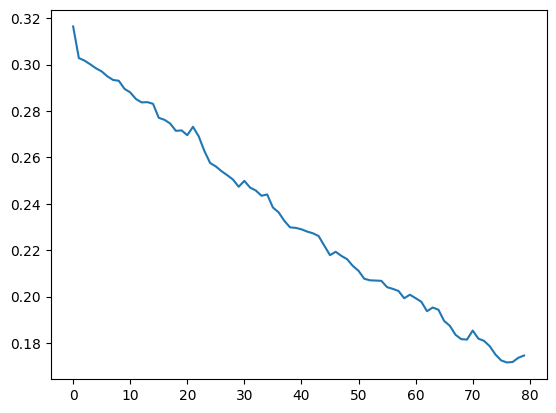

In [ ]:
plt.plot(history.epoch, history.history['loss'], label='total loss')
plt.show()

In [ ]:
def predict_next_note(
    notes: np.ndarray, 
    keras_model: tf.keras.Model, 
    temperature: float = 1.0) -> int:
  """Generates a note IDs using a trained sequence model."""

  assert temperature > 0

  # Add batch dimension
  inputs = tf.expand_dims(notes, 0)

  predictions = model.predict(inputs)
  pitch_logits = predictions['pitch']
  step = predictions['step']
  duration = predictions['duration']

  pitch_logits /= temperature
  pitch = tf.random.categorical(pitch_logits, num_samples=1)
  pitch = tf.squeeze(pitch, axis=-1)
  duration = tf.squeeze(duration, axis=-1)
  step = tf.squeeze(step, axis=-1)

  # `step` and `duration` values should be non-negative
  step = tf.maximum(0, step)
  duration = tf.maximum(0, duration)

  return int(pitch), float(step), float(duration)

In [ ]:
temperature = 2
num_predictions = 15

sample_notes = np.stack([raw_notes[key] for key in key_order], axis=1)

# The initial sequence of notes; pitch is normalized similar to training
# sequences

#Duration and step is set to 0.5 as the model fails to create non-zero values for these.
dur = 0.25
stp = 0.25

#input_notes = (sample_notes[:seq_length] / np.array([vocab_size, 1, 1]))

#Create your own input!
input_notes = ([(66, 0, dur), (66, stp, dur), (66, stp, dur), (67, stp, dur), (68, stp, dur), 
                (64, 0, dur), (66, stp, dur), (64, stp, dur), (63, stp, dur), (65, stp, dur),
                (64, 0, dur), (66, stp, dur), (64, stp, dur), (63, stp, dur), (65, stp, dur), 
                (64, 0, dur), (66, stp, dur), (64, stp, dur), (63, stp, dur), (65, stp, dur),
                (64, 0, dur), (66, stp, dur), (64, stp, dur), (63, stp, dur), (65, stp, dur)])

generated_notes = []
new_notes = []
prev_start = 0

#Adding the input to generated notes
for i in input_notes:
  
  duration = dur # TODO! CHANGE
  step = stp     # TODO! CHANGE
  start = prev_start + step
  end = start + duration
  generated_notes.append((i[0], step, duration, start, end))
  prev_start = start

for _ in range(num_predictions):
  pitch = -1
  while (pitch < 40 or pitch > 80): #Filters out "Impossible" notes
    pitch, step, duration = predict_next_note(input_notes, model, temperature)
  #Duration and step is set to 0.5 as the model fails to create non-zero values for these.
  #duration = dur # TODO! CHANGE
  step = duration     # TODO! CHANGE
  start = prev_start + step
  end = start + duration
  input_note = (pitch, step, duration)
  generated_notes.append((*input_note, start, end))
  new_notes.append((*input_note, start, end))
  input_notes = np.delete(input_notes, 0, axis=0)
  input_notes = np.append(input_notes, np.expand_dims(input_note, 0), axis=0)
  print(len(generated_notes))
  print(pitch)
  prev_start = start

generated_notes = pd.DataFrame(
    generated_notes, columns=(*key_order, 'start', 'end'))
new_notes = pd.DataFrame(
    new_notes, columns=(*key_order, 'start', 'end'))

1/1 [==============================] - 2s 2s/step
26
62
1/1 [==============================] - 0s 34ms/step
27
57
1/1 [==============================] - 0s 37ms/step
28
68
1/1 [==============================] - 0s 40ms/step
29
61
1/1 [==============================] - 0s 50ms/step
30
50
1/1 [==============================] - 0s 34ms/step
31
67
1/1 [==============================] - 0s 41ms/step
32
65
1/1 [==============================] - 0s 40ms/step
33
56
1/1 [==============================] - 0s 42ms/step
34
48
1/1 [==============================] - 0s 25ms/step
35
79
1/1 [==============================] - 0s 24ms/step
36
68
1/1 [==============================] - 0s 26ms/step
37
65
1/1 [==============================] - 0s 33ms/step
38
64
1/1 [==============================] - 0s 26ms/step
39
51
1/1 [==============================] - 0s 27ms/step
40
63


In [ ]:
new_notes.head(15)

,pitch,step,duration,start,end
0,62,0.242404,0.242404,6.492404,6.734808
1,57,0.242405,0.242405,6.734809,6.977214
2,68,0.242404,0.242404,6.977213,7.219617
3,61,0.242405,0.242405,7.219618,7.462022
4,50,0.242405,0.242405,7.462022,7.704427
5,67,0.242398,0.242398,7.704420,7.946819
6,65,0.242400,0.242400,7.946821,8.189221
7,56,0.242400,0.242400,8.189220,8.431620
8,48,0.242398,0.242398,8.431619,8.674017
9,79,0.242394,0.242394,8.674012,8.916406


In [ ]:
def notes_to_midi(
  notes: pd.DataFrame,
  out_file: str, 
  instrument_name: str,
  velocity: int = 100,  # note loudness
) -> pretty_midi.PrettyMIDI:

  pm = pretty_midi.PrettyMIDI()
  instrument = pretty_midi.Instrument(
      program=pretty_midi.instrument_name_to_program(
          instrument_name))

  prev_start = 0
  for i, note in notes.iterrows():
    start = float(prev_start + note['step'])
    end = float(start + note['duration'])
    note = pretty_midi.Note(
        velocity=velocity,
        pitch=int(note['pitch']),
        start=start,
        end=end,
    )
    instrument.notes.append(note)
    prev_start = start

  pm.instruments.append(instrument)
  pm.write(out_file)
  return pm

In [ ]:
from google.colab import files

out_file = 'output_En_Kr_A.mid'
out_pm = notes_to_midi(
    generated_notes, out_file=out_file, instrument_name = "Acoustic Grand Piano")
files.download(out_file)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
import numpy as np

input_notes = [1,2,3,4,5]
input_note = 6

input_notes = np.delete(input_notes, 0, axis=0)
input_notes = np.append(input_notes, np.expand_dims(input_note, 0), axis=0)

print(input_notes)

[2 3 4 5 6]


1/1 [==============================] - 0s 26ms/step
0


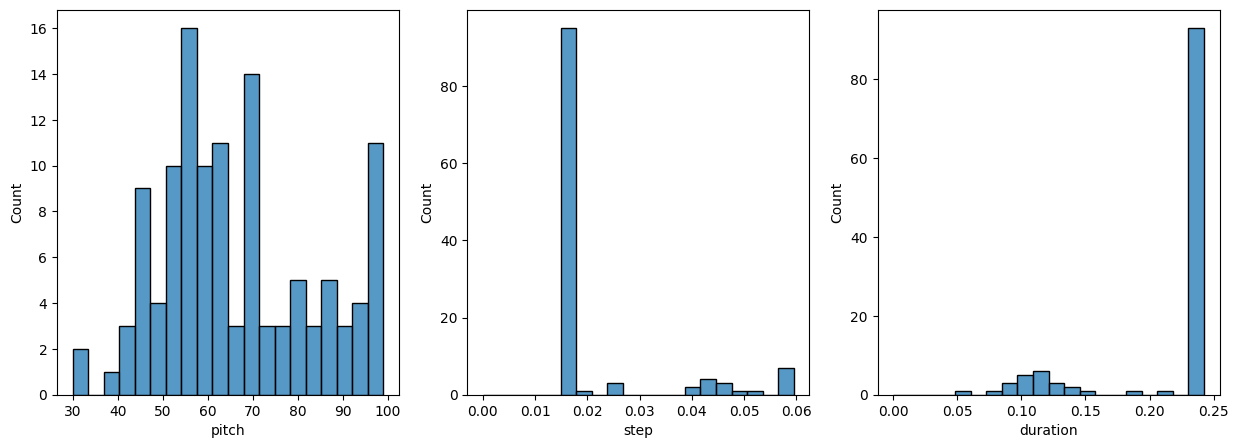

In [ ]:
sample_notes = np.stack([raw_notes[key] for key in key_order], axis=1)
input_notes = (
    sample_notes[:seq_length] / np.array([vocab_size, 1, 1]))
temperature = 2
generated_notes = []
c = 0
for _ in range(120):

  pitch = -1
  #while (pitch < 50 or pitch > 80): #Filters out "Impossible" notes
  pitch, step, duration = predict_next_note(input_notes, model, temperature)
  #c += 1
  #Duration and step is set to 0.5 as the model fails to create non-zero values for these.
  #duration = dur # TODO! CHANGE
 # step = duration     # TODO! CHANGE
  start = prev_start + step
  end = start + duration
  input_note = (pitch, step, duration)
  generated_notes.append((*input_note, start, end))
  input_notes = np.delete(input_notes, 0, axis=0)
  input_notes = np.append(input_notes, np.expand_dims(input_note, 0), axis=0)
  prev_start = start

generated_notes = pd.DataFrame(
    generated_notes, columns=(*key_order, 'start', 'end'))
plot_distributions(generated_notes)

print(c)


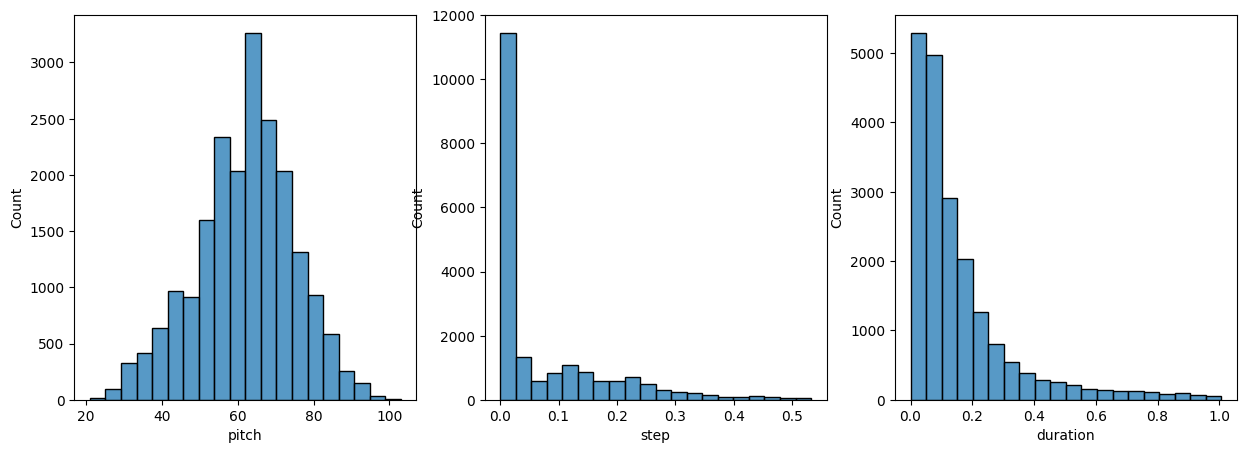

In [ ]:
plot_distributions(all_notes)

In [ ]:
model.save('/content/saved_model/model_En_Kr_A', save_format='h5')